# Google PlayStore Data

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
%matplotlib inline

In [135]:
# reading the data
df = pd.read_csv('/Users/chrisgabriel/Desktop/CSV files/Google_data_cleaned.csv')
df.head()

,Unnamed: 0,app,category,rating,reviews,installs,type,price,content_rating,genres,current_ver,android_ver,size(kb),update_month,update_year
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,10000,0,0.0,Everyone,Art & Design,1.0.0,4.0.3,19000.0,1,2018
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,500000,0,0.0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3,14000.0,1,2018
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,5000000,0,0.0,Everyone,Art & Design,1.2.4,4.0.3,8.7,8,2018
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,50000000,0,0.0,Teen,Art & Design,NaN,4.2,25000.0,6,2018
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,100000,0,0.0,Everyone,Art & Design;Creativity,1.1,4.4,2.8,6,2018


In [136]:
#checking data set
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9658 entries, 0 to 9657
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app             9658 non-null   object 
 1   category        9658 non-null   object 
 2   rating          8196 non-null   float64
 3   reviews         9658 non-null   int64  
 4   installs        9658 non-null   int64  
 5   type            9658 non-null   int64  
 6   price           9658 non-null   float64
 7   content_rating  9658 non-null   object 
 8   genres          9658 non-null   object 
 9   current_ver     8596 non-null   object 
 10  android_ver     8667 non-null   object 
 11  size(kb)        8432 non-null   float64
 12  update_month    9658 non-null   int64  
 13  update_year     9658 non-null   int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 1.0+ MB


Missing data observed, and a non-null count under 9658 means missing values. 
The 'rating' column has 8196, etc.

In [137]:
#approx null values
df[['rating','current_ver','android_ver','size(kb)']].isnull().sum()

rating         1462
current_ver    1062
android_ver     991
size(kb)       1226
dtype: int64

Only four columns have NA values. These columns cannot have a manual or aggregated input, so they will be dropped later.

In [138]:
# finding the sum of installs, price, rating, and reviews per content rating
pivot1= df[['content_rating','installs','price','rating','reviews']]
pivot1.pivot_table(index='content_rating',
               aggfunc='mean', margins=True)

,installs,price,rating,reviews
content_rating,,,,
Adults only 18+,6.666667e+05,0.000000,4.300000,27116.000000
Everyone,6.602474e+06,1.229916,4.166319,164535.809946
Everyone 10+,1.251175e+07,0.435202,4.225902,627190.408100
Mature 17+,6.203529e+06,0.259847,4.121849,221471.249364
Teen,1.591436e+07,0.633475,4.225658,485803.292471
Unrated,2.525000e+04,0.000000,4.100000,593.500000
All,9.165090e+06,1.037884,4.173243,255251.470717


We can find the average acitivity given content, but note that adult and unrated have zero pricing. 

In [139]:
#extracting data
df.loc[(df['content_rating']=='Adults only 18+') |
       (df['content_rating']=='Unrated')]

,app,category,rating,reviews,installs,type,price,content_rating,genres,current_ver,android_ver,size(kb),update_month,update_year
262,Manga Master - Best manga & comic reader,COMICS,4.6,24005,500000,0,0.0,Adults only 18+,Comics,1.1.7.0,4.1,4.9,7,2018
2378,DraftKings - Daily Fantasy Sports,SPORTS,4.5,50017,1000000,0,0.0,Adults only 18+,Sports,3.21.324,4.4,41000.0,7,2018
5415,Manga Books,COMICS,3.8,7326,500000,0,0.0,Adults only 18+,Comics,NaN,NaN,NaN,8,2018
6267,Best CG Photography,FAMILY,NaN,1,500,0,0.0,Unrated,Entertainment,5.2,3.0,2.5,6,2015
7189,DC Universe Online Map,TOOLS,4.1,1186,50000,0,0.0,Unrated,Tools,1.3,2.3.3,6.4,2,2012


Looking at the app names when can see these apps do not typically charge for usage. Values will be left in the data set. 

## Wrangle data

In [140]:
# types var: paid=1 free=0
df['type'].value_counts()

0    8902
1     756
Name: type, dtype: int64

In [141]:
# creating a new column based on condition
def assign_value(row):
    if row == 1:
        return 'Paid'
    else:
        return 'Free'
    
df['transaction'] = df['type'].apply(assign_value)
df['transaction'].value_counts()

Free    8902
Paid     756
Name: transaction, dtype: int64

In [142]:
# transforming the column into a categorical variable
df['type']= df['type'].astype(object)
df[['transaction','type']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9658 entries, 0 to 9657
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   transaction  9658 non-null   object
 1   type         9658 non-null   object
dtypes: object(2)
memory usage: 151.0+ KB


### Reviews and pricing

In [143]:
# stats for the apps that were paid
paid_apps= df[(df['transaction']=='Paid')]
paid_apps.describe()

,rating,reviews,installs,price,size(kb),update_month,update_year
count,604.000000,7.560000e+02,7.560000e+02,756.000000,685.000000,756.000000,756.000000
mean,4.259603,8.724888e+03,7.587947e+04,14.045146,17238.126569,6.322751,2016.679894
std,0.559961,8.988612e+04,5.389844e+05,58.743615,23374.588112,3.049101,1.554542
min,1.000000,0.000000e+00,0.000000e+00,0.990000,1.000000,1.000000,2011.000000
25%,4.100000,6.000000e+00,1.000000e+02,1.490000,4.700000,4.000000,2016.000000
50%,4.400000,8.800000e+01,1.000000e+03,2.990000,899.000000,6.000000,2017.000000
75%,4.600000,1.213750e+03,1.000000e+04,4.990000,27000.000000,8.000000,2018.000000
max,5.000000,2.376564e+06,1.000000e+07,400.000000,100000.000000,12.000000,2018.000000


The maximum price hits $400 for one app download. Not a very typical customer purchase.  

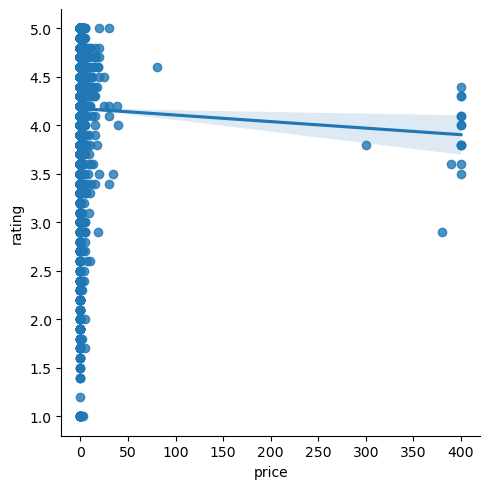

In [144]:
sns.lmplot(x='price', y='rating', data=df)

They will be ruled as outliers.

In [145]:
# payment to be below or equal to $11, popularity based on reviews then rating and installs
paid=df.loc[(df['price']<=11.0) & (df['transaction']=='Paid')].sort_values(['reviews','rating','installs'], ascending=False).dropna()
paid.head()

,app,category,rating,reviews,installs,type,price,content_rating,genres,current_ver,android_ver,size(kb),update_month,update_year,transaction
3208,Hitman Sniper,GAME,4.6,408292,10000000,1,0.99,Mature 17+,Action,1.7.110758,4.1,29000.0,7,2018,Paid
6370,Grand Theft Auto: San Andreas,GAME,4.4,348962,1000000,1,6.99,Mature 17+,Action,1.08,3.0,26000.0,3,2015,Paid
7743,Bloons TD 5,FAMILY,4.6,190086,1000000,1,2.99,Everyone,Strategy,3.16,2.3.3,94000.0,7,2018,Paid
8537,Where's My Water?,FAMILY,4.7,188740,1000000,1,1.99,Everyone,Puzzle;Brain Games,1.16.0,4.2,69000.0,7,2018,Paid
1744,Card Wars - Adventure Time,FAMILY,4.3,129603,1000000,1,2.99,Everyone 10+,Card;Action & Adventure,1.11.0,2.3.3,23000.0,2,2016,Paid


<Figure size 1500x600 with 0 Axes>

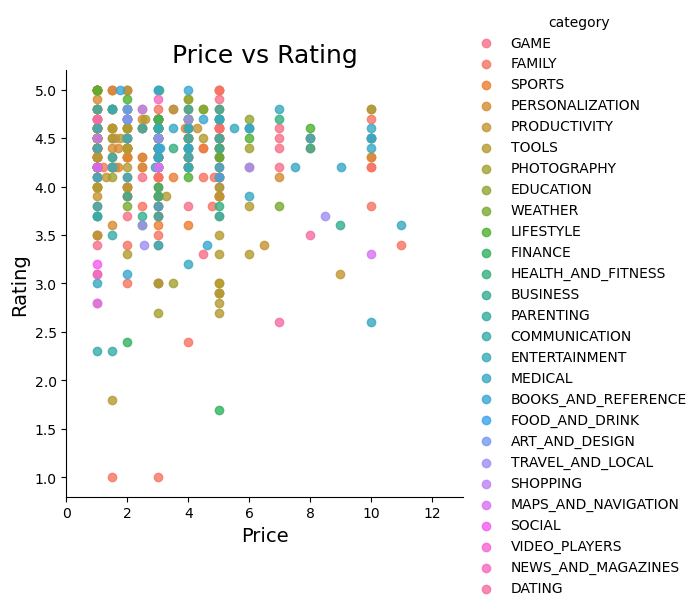

In [146]:
# new plot with NA's dropped
plt.figure(figsize=(15, 6))

sns.lmplot(x='price', y='rating', data=paid, fit_reg=False, hue='category')
plt.xlim(xmin=0, xmax=13)
plt.title("Price vs Rating", fontsize=18)
plt.xlabel("Price", fontsize=14)
plt.ylabel("Rating", fontsize=14)
plt.show()

Higher priced apps have less negative reviews, but lower engagment.  

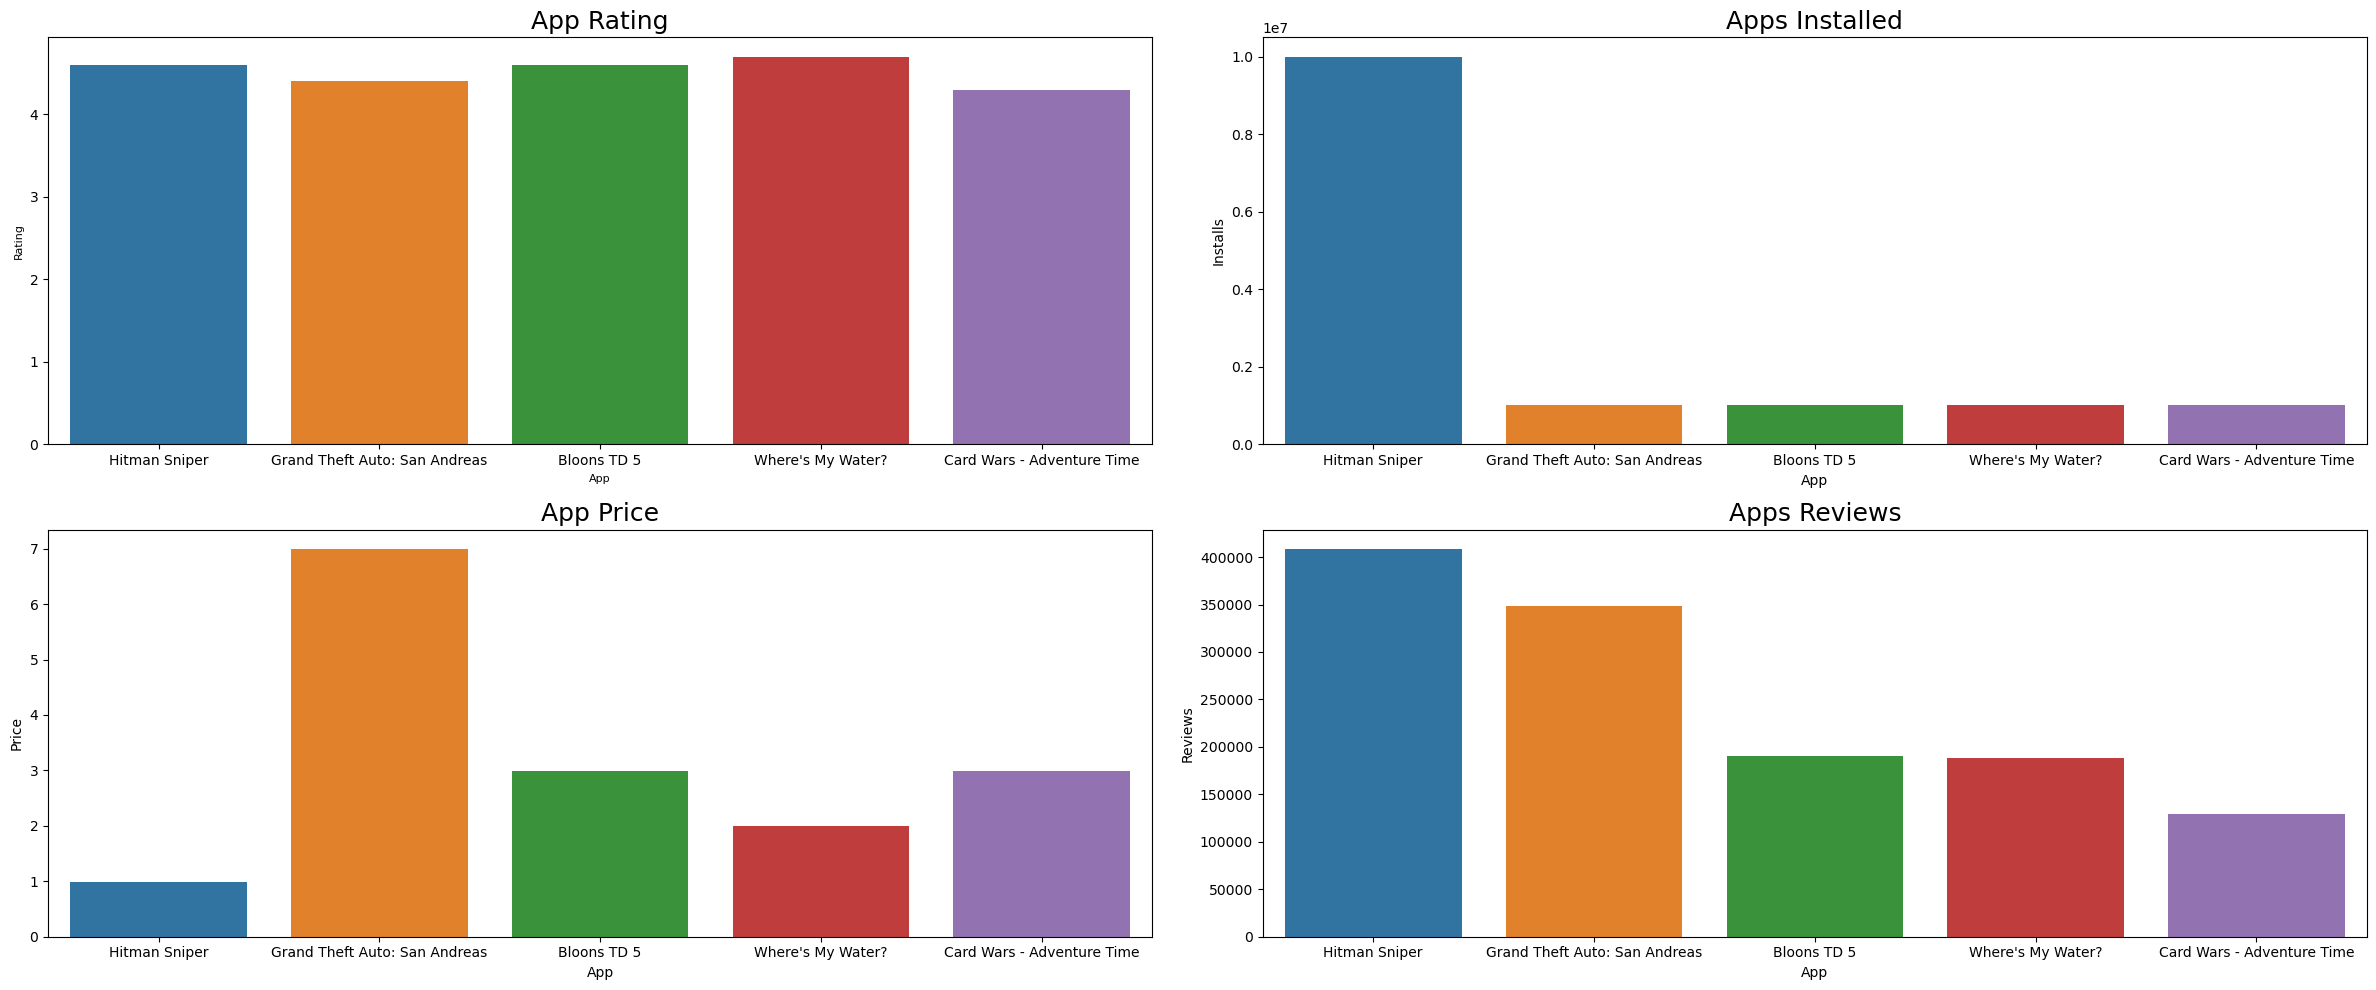

In [147]:
# top five apps
paid=paid.head(5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 10))

plt.subplot(2, 2, 1) 
sns.barplot(data=paid, x="app", y="rating")
plt.title("App Rating", fontsize=18)
plt.xlabel("App", fontsize=8)
plt.ylabel("Rating", fontsize=8)

plt.subplot(2, 2, 2) 
sns.barplot(data=paid, x="app", y="installs")
plt.title("Apps Installed", fontsize=18)
plt.xlabel("App", fontsize=10)
plt.ylabel("Installs", fontsize=10)

plt.subplot(2, 2, 3) 
sns.barplot(data=paid, x="app", y="price")
plt.title("App Price", fontsize=18)
plt.xlabel("App", fontsize=10)
plt.ylabel("Price", fontsize=10)

plt.subplot(2, 2, 4) 
sns.barplot(data=paid, x="app", y="reviews")
plt.title("Apps Reviews", fontsize=18)
plt.xlabel("App", fontsize=10)
plt.ylabel("Reviews", fontsize=10)

fig.tight_layout()

plt.show()

## Visualize df

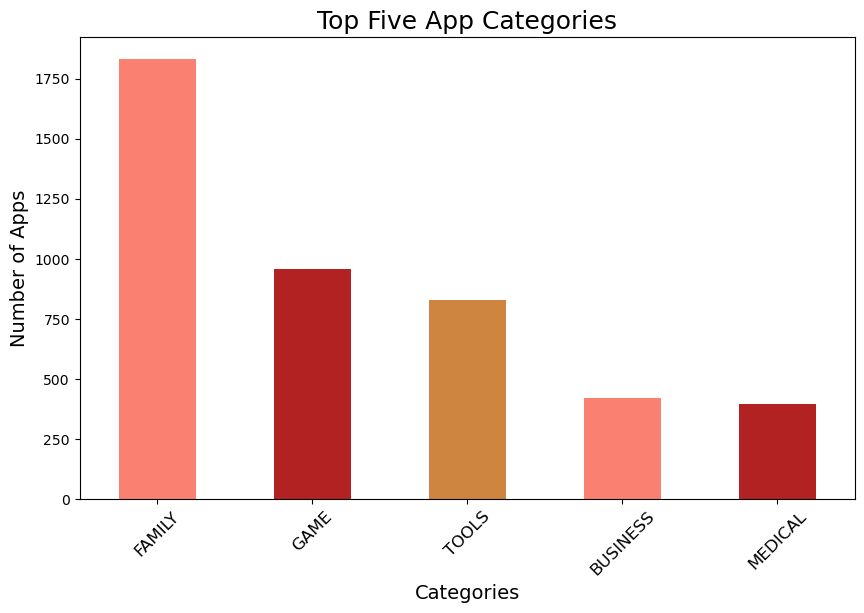

In [148]:
# trim down the data set
result= df['category'].value_counts().head(5)
my_colors= ['salmon','firebrick','peru']
# Create a bar plot for the top 5 categories
plt.figure(figsize=(10, 6))
result.plot(kind='bar', color=my_colors)

plt.title("Top Five App Categories", fontsize=18)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Number of Apps", fontsize=14)
plt.xticks(rotation=45, fontsize=12)

# Display the plot
plt.show()

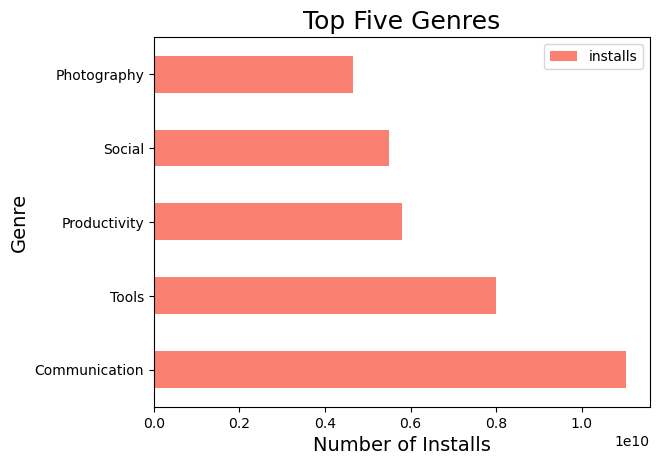

,installs
genres,
Communication,11038276251
Tools,7991771915
Productivity,5793091369
Social,5487867902
Photography,4649147655


In [149]:
# finding the top 5 genres
result2= df[['genres','installs']].groupby('genres').sum()
result2=result2.sort_values(['installs'], ascending=False).head(5) #higher values first
result2.plot(kind='barh', color='salmon')

# plot
plt.title("Top Five Genres", fontsize=18)
plt.xlabel("Number of Installs", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.show()
result2

In [150]:
# most popular apps
df[['app','installs','genres']].sort_values(['installs'], ascending=False).head(10)

,app,installs,genres
300,WhatsApp Messenger,1000000000,Communication
152,Google Play Books,1000000000,Books & Reference
1356,Subway Surfers,1000000000,Arcade
2420,Maps - Navigate & Explore,1000000000,Travel & Local
304,Gmail,1000000000,Communication
2003,Instagram,1000000000,Social
2002,Facebook,1000000000,Social
302,Google Chrome: Fast & Secure,1000000000,Communication
2012,Google+,1000000000,Social
2908,YouTube,1000000000,Video Players & Editors


The most popular apps on the playstore. 

### Data Frame with no Null Values

In [162]:
#statistics
#dropping all null values
df = df.dropna(how='any')
df.info()
df[['rating','reviews','price','installs']].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6950 entries, 0 to 9654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app             6950 non-null   object 
 1   category        6950 non-null   object 
 2   rating          6950 non-null   float64
 3   reviews         6950 non-null   int64  
 4   installs        6950 non-null   int64  
 5   type            6950 non-null   object 
 6   price           6950 non-null   float64
 7   content_rating  6950 non-null   object 
 8   genres          6950 non-null   object 
 9   current_ver     6950 non-null   object 
 10  android_ver     6950 non-null   object 
 11  size(kb)        6950 non-null   float64
 12  update_month    6950 non-null   int64  
 13  update_year     6950 non-null   int64  
 14  transaction     6950 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 868.8+ KB


,rating,reviews,price,installs
count,6950.000000,6.950000e+03,6950.000000,6.950000e+03
mean,4.159468,1.437820e+05,1.181334,4.338750e+06
std,0.560579,1.027497e+06,18.296991,2.652671e+07
min,1.000000,1.000000e+00,0.000000,1.000000e+00
25%,4.000000,8.300000e+01,0.000000,1.000000e+04
50%,4.300000,1.485000e+03,0.000000,1.000000e+05
75%,4.500000,2.579025e+04,0.000000,1.000000e+06
max,5.000000,4.489172e+07,400.000000,1.000000e+09


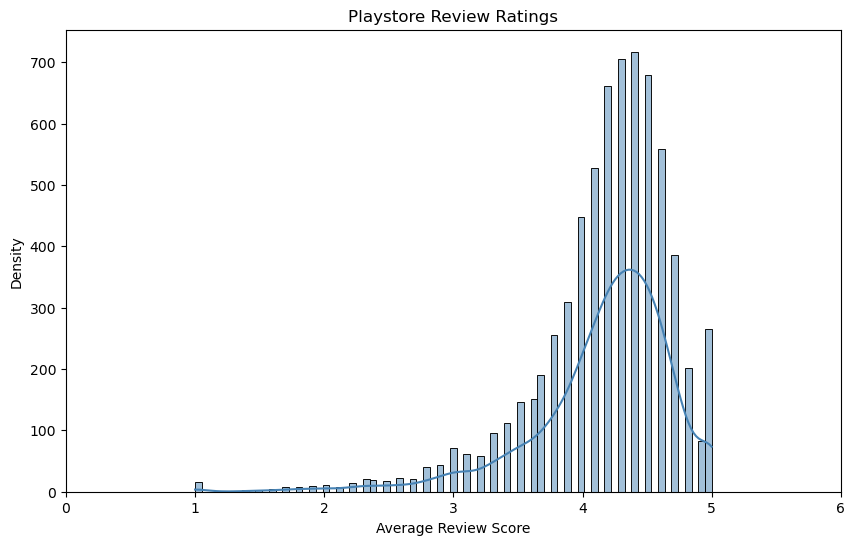

In [152]:
# reviews with NA values dropped
plt.figure(figsize=(10,6))
sns.histplot(df, x = 'rating', color= 'steelblue',
            kde=True)

plt.xlim(xmin=0, xmax=6)
plt.xlabel('Average Review Score')
plt.ylabel('Density')
plt.title('Playstore Review Ratings')

plt.show()

The Google Play platform offers customers what they need as apps generally have 4-5 star ratings.

Text(0.5, 1.0, 'App Rating Based on ESRB')

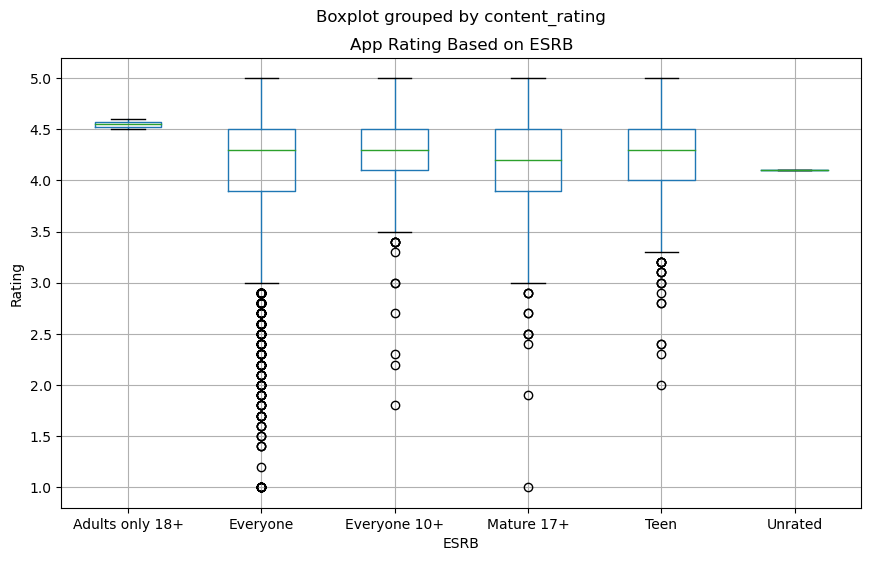

In [153]:
# app ratings based on ESRB
ax = df[['rating', 'content_rating']].boxplot(by='content_rating', 
                                               figsize=(10,6))
ax.set_ylabel('Rating')
ax.set_xlabel('ESRB')
ax.set_title('App Rating Based on ESRB')